# Рубежный контроль №2

## Серов Сергей ИУ5-22М

### Вариант 13

#### Задача №2.

Для заданного набора данных постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения модели используйте ансамблевые модели: случайный лес и градиентный бустинг. Оцените качество модели на основе подходящих метрик качества (не менее трех метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей?

Набор данных:   [kaggle.com (World University Rankings)](https://www.kaggle.com/mylesoneill/world-university-rankings?select=cwurData.csv)

Решается **задача регрессии** с использованием ключевого признака "patents"

In [2]:
from google.colab import files
# files.upload()

!ls -lha kaggle.json

!pip install -q kaggle


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets list

!kaggle datasets download -d mylesoneill/world-university-rankings
!unzip /content/world-university-rankings.zip

!head cwurData.csv


-rw-r--r-- 1 root root 64 May 20 15:40 kaggle.json
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-19 04:32:24          68858  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           9623  
timxia/enriched-global-mobility-data-apple-google           Enriched Global Mobility Data (Apple + Google)        3MB  2020-05-04 06:52:35            417  
mrmorj/political-advertisements-from-facebook               Political Advertisements from Facebook              237MB  2020-05-05 18:53:51            261  
susuwatari/ep

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
# from gmdhpy import gmdh
%matplotlib inline 
sns.set(style="ticks")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('cwurData.csv', sep=",")
# data = pd.get_dummies(data)
data.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [5]:
# размер набора данных
data.shape

(2200, 14)

In [6]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 2200


## Обработка пропусков в данных

In [7]:
# проверим есть ли пропущенные значения
data.isnull().sum()

world_rank                0
institution               0
country                   0
national_rank             0
quality_of_education      0
alumni_employment         0
quality_of_faculty        0
publications              0
influence                 0
citations                 0
broad_impact            200
patents                   0
score                     0
year                      0
dtype: int64

In [8]:
data_all = data.dropna(axis=0, how='any')
(data.shape, data_all.shape)

# Удаление колонок, содержащих пустые значения

((2200, 14), (2000, 14))

In [9]:
data_all.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
200,1,Harvard University,USA,1,1,1,1,1,1,1,1.0,2,100.00,2014
201,2,Stanford University,USA,2,11,2,4,5,3,3,4.0,6,99.09,2014
202,3,Massachusetts Institute of Technology,USA,3,3,11,2,15,2,2,2.0,1,98.69,2014
203,4,University of Cambridge,United Kingdom,1,2,10,5,10,9,12,13.0,48,97.64,2014
204,5,University of Oxford,United Kingdom,2,7,12,10,11,12,11,12.0,16,97.51,2014


## Выбор признаков, подходящих для построения моделей.

In [10]:
data_all.dtypes

world_rank                int64
institution              object
country                  object
national_rank             int64
quality_of_education      int64
alumni_employment         int64
quality_of_faculty        int64
publications              int64
influence                 int64
citations                 int64
broad_impact            float64
patents                   int64
score                   float64
year                      int64
dtype: object

 Для построения моделей будем использовать только количественные признаки, кроме признака "Unnamed: 0". 

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения

In [13]:
corr_cols = ['world_rank', 'national_rank', 'publications', 'patents', 'year']
corr_cols

['world_rank', 'national_rank', 'publications', 'patents', 'year']

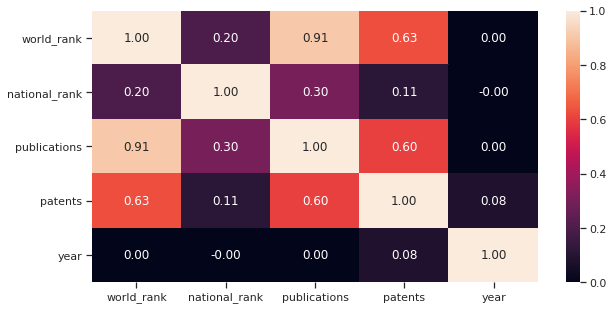

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data_all[corr_cols].corr(), annot=True, fmt='.2f')

На основе корреляционной матрицы можно сделать следующие выводы:

- Целевой признак регрессии "Overall" наиболее сильно коррелирует с "Potential" (0.66) и "Special" (0.61). Эти признаки обязательно следует оставить в модели регрессии.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

## Выбор метрик для последующей оценки качества моделей.

### В качестве метрик для решения задачи регрессии будем использовать:
1. Mean absolute error - средняя абсолютная ошибка
![image.png](attachment:image.png)

Чем ближе значение к нулю, тем лучше качество регрессии.

Основная проблема метрики состоит в том, что она не нормирована.

Вычисляется с помощью функции mean_absolute_error.

2. Mean squared error - средняя квадратичная ошибка
![image.png](attachment:image.png)

Вычисляется с помощью функции mean_squared_error.

3. Метрика R2 или коэффициент детерминации
![image.png](attachment:image.png)

Вычисляется с помощью функции r2_score.

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

## Формирование обучающей и тестовой выборок на основе исходного набора данных

In [0]:
# Признаки для задачи регресии
task_regr_cols = ['world_rank', 'national_rank', 'publications', 'patents', 'year']

In [19]:
# Разделение выборки на обучающую и тестовую
regr_X_train, regr_X_test, regr_Y_train, regr_Y_test = train_test_split(
    data_all[task_regr_cols], data_all['patents'], test_size=0.5, random_state=1)
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((1000, 5), (1000, 5), (1000,), (1000,))

## Решение задачи регрессии

In [0]:
# Модели
regr_models = {'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [0]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [0]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [23]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)
    # print(type(model_name),'---',type(model),'---',type(regrMetricLogger))

*****************************************************
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE=0.602, MSE=1.32, R2=1.0
*****************************************************
*****************************************************
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
          

## Формирование выводов о качестве построенных моделей на основе выбранных метрик.

In [24]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

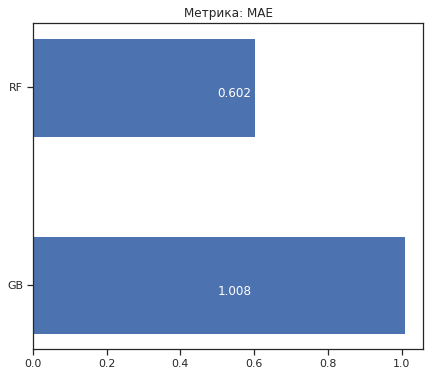

In [25]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

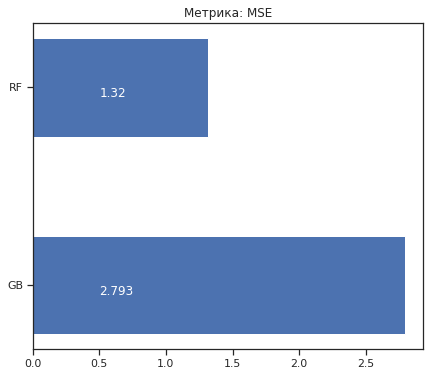

In [26]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

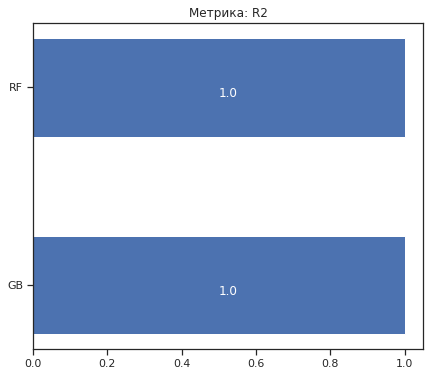

In [27]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

### Вывод: лучшей оказалась модель на основе градиентного бустинга.